# Generalized Lasso Problem

## 1-D Case (Total Variation Denoising and Trend Filtering)

The first part of the project covers the simple 1-D case of the fused lasso, also called the total variation denoising in 1D.

### Primal Subgradient Method

In [1]:
import numpy as np
import numpy.random as rn
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse import linalg as spla

In [2]:
# Generate 1D data
def data(size):
    y = np.zeros((size,1))
    y[0:size/5] = 20*rn.random((size/5,1)) + 50
    y[size/5:3*size/5] = 15*rn.random((2*size/5,1)) + 30
    y[3*size/5:4*size/5] = 20*rn.random((size/5,1)) + 60
    y[4*size/5:size] = 10*rn.random((size/5,1)) + 90
    return y

# Penalty Matrix for TV Denoising
def denoisingMat(size):
    add = np.concatenate((np.zeros((size-1,1)),np.eye(size-1)), axis = 1)
    sub = np.concatenate((-np.eye(size-1),np.zeros((size-1,1))), axis = 1)
    D = add + sub
    return D

def trendFilteringLinearMat(size):
    add1 = np.concatenate((np.zeros((size-2,2)),np.eye(size-2)), axis = 1)
    sub = np.concatenate((np.zeros((size-2,1)),np.concatenate((-2*np.eye(size-2),np.zeros((size-2,1))), axis = 1)), axis = 1)
    add2 = np.concatenate((np.eye(size-2),np.zeros((size-2,2))), axis = 1)
    D = add1 + sub + add2
    return D

In [3]:
def costFunc(y, beta, D, lam):
    fVal = 0.5*la.norm(y - beta)**2 + lam*la.norm(np.dot(D,beta),ord = 1)
    return fVal

def subgradient(y, beta, D, t, lam, c=1e-1):
    delF1 = beta - y
    delF2 = np.dot(D.T,np.sign(np.dot(D,beta)))*lam
    delF = delF1 + delF2
    beta = beta - c/(np.sqrt(t+1))*(delF)
    return beta

size = 1000
y = data(size)

def descent(update, y, reg, T=int(5e3)):
    size = y.shape[0]
    D = denoisingMat(size)
#     D = trendFilteringLinearMat(size)
    beta = np.zeros((size,1))
    error = []
    l1 = []
    for t in xrange(T):
        beta = update(y, beta, D, t, reg)
        # record error and l1 norm
        if (t % 10 == 0) or (t == T - 1):
            error.append(la.norm(beta - y))
            l1.append(np.sum(np.abs(np.dot(D,beta))))
            print t
            assert not np.isnan(error[-1])

    return beta, error, l1

In [4]:
beta_sg10, error_sg10, l1_sg10 = descent(subgradient, y, reg=10)
beta_sg5, error_sg5, l1_sg5 = descent(subgradient, y, reg=5)
beta_sg20, error_sg20, l1_sg20 = descent(subgradient, y, reg=20)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

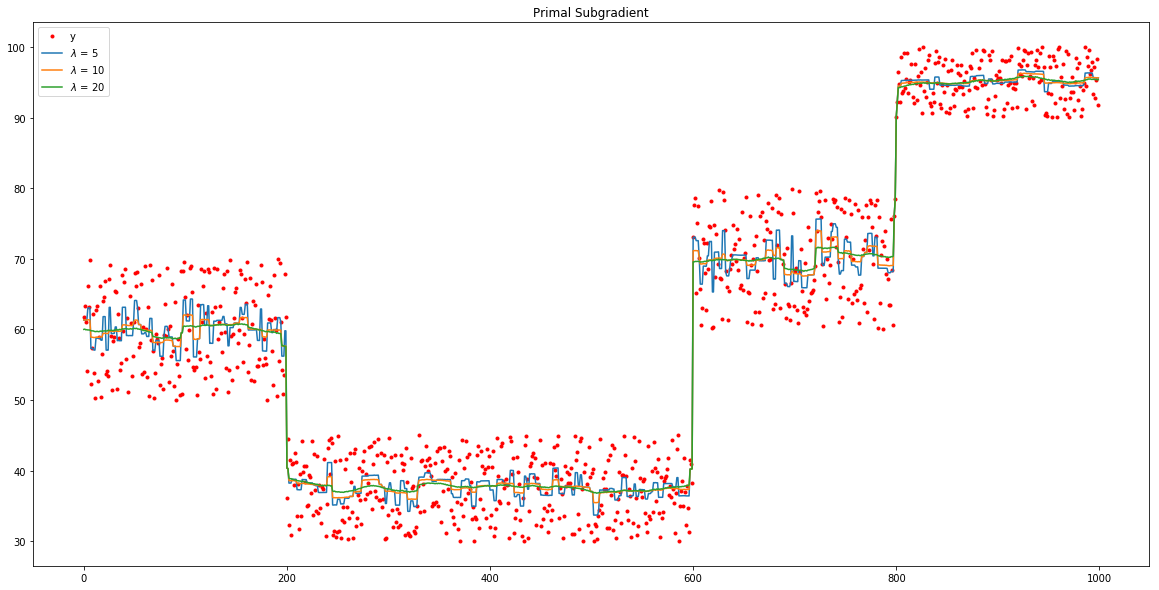

In [5]:
plt.clf()
plt.figure(figsize=(20,10))
plt.plot(y, 'r.',label='y')
plt.plot(beta_sg5,label='$\lambda$ = 5')
plt.plot(beta_sg10,label='$\lambda$ = 10')
plt.plot(beta_sg20,label='$\lambda$ = 20')
plt.title('Primal Subgradient')
plt.legend()
plt.show()

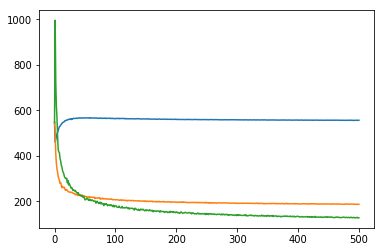

In [6]:
plt.plot(l1_sg5)
plt.plot(l1_sg10)
plt.plot(l1_sg20)
plt.show()

### Dual Proximal Gradient Method

In [7]:
def costFuncDualProx(y, v):
    fVal = 0.5*(np.dot(y.T,y) - np.dot((y+v).T,(y+v)))
    return fVal

def gradientDualProx(y, u, D, lam, c=1e-1):
    delFStar = -np.dot(D,(y - np.dot(D.T,u)))
    u = u - c*(delFStar)
    u[u > lam] = lam
    u[u < -lam] = -lam
    return u

def descentDualProx(update, y, reg, T=int(5e3)):
    size = y.shape[0]
    D = denoisingMat(size)
#     D = trendFilteringLinearMat(size)
    beta = np.zeros((size,1))
    u = np.zeros((D.shape[0],1))
    
    error = []
    l1 = []
    for t in xrange(T):
        u = update(y, u, D, reg)
        # record error and l1 norm
        if (t % 10 == 0) or (t == T - 1):
            beta = y - np.dot(D.T,u)
#             error.append(la.norm(beta - y))
            error.append(costFuncDualProx(y, -np.dot(D.T,u)))
            l1.append(np.sum(np.abs(np.dot(D,beta))))
            print t
            assert not np.isnan(error[-1])
    
    return beta, error, l1

In [8]:
beta_dpg5, error_dpg5, l1_dpg5 = descentDualProx(gradientDualProx, y, reg=5)
beta_dpg10, error_dpg10, l1_dpg10 = descentDualProx(gradientDualProx, y, reg=10)
beta_dpg20, error_dpg20, l1_dpg20 = descentDualProx(gradientDualProx, y, reg=20)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

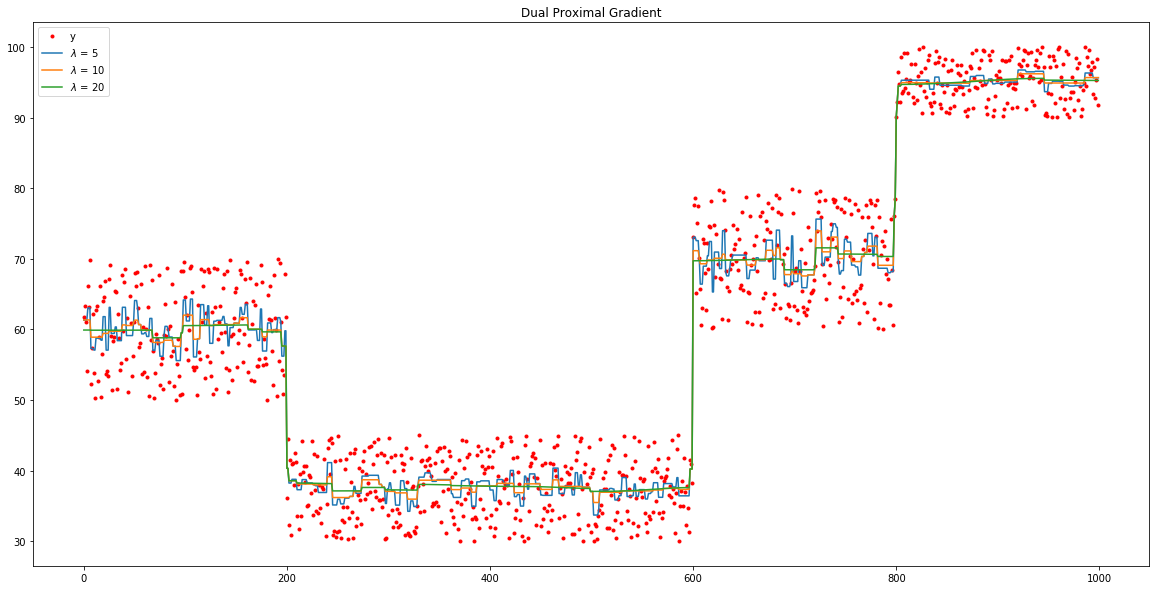

In [9]:
plt.clf()
plt.figure(figsize=(20,10))
plt.plot(y, 'r.',label='y')
# plt.plot(beta_dpg0,label='$\lambda$ = 0')
plt.plot(beta_dpg5,label='$\lambda$ = 5')
plt.plot(beta_dpg10,label='$\lambda$ = 10')
plt.plot(beta_dpg20,label='$\lambda$ = 20')
# plt.plot(beta_dp,label='DP')
plt.title('Dual Proximal Gradient')
plt.legend()
plt.show()

In [10]:
beta_dpg0, error_dpg0, l1_dpg0 = descentDualProx(gradientDualProx, y, reg=0)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

### Fast Dual Path Algorithm

In [11]:
def descentDualPath(y, reg):
    size = y.shape[0]
    D = denoisingMat(size)
    totalSet = np.arange(D.shape[0])
    x = spla.lsqr(D.T,y.flatten())
    u = x[0]
    uVec = np.expand_dims(u,1)
    beta = y - np.dot(D.T,uVec)
    lam = np.max(np.abs(u))
    iHit = np.argmax(np.abs(u))
    B = np.array([iHit])
    sgn = np.sign(u[iHit])
    s = np.array([sgn])
    counter = 0
    
    while lam > 0:
        print counter
        counter = counter + 1
        
        BMinus = setExclusion(B, totalSet)
        if BMinus.size == 0:
            break
        
        DBMinus = D[BMinus,:]
        DB = D[B,:]
        x1 = spla.lsqr(DBMinus.T,y.flatten())
        x2 = spla.lsqr(DBMinus.T, np.dot(DB.T,np.expand_dims(s,1)))
        a = x1[0]
        b = x2[0]
        tHit, iHit = hittingCoordinate(a, b, BMinus, lam)

        lam = tHit
        BOld = B.copy()
        B = np.append(B,iHit)
        sgn = np.sign(u[iHit])
        sOld = s.copy()
        s = np.append(s, sgn)
        print lam
        
        if lam < reg:
            u[BMinus] = a - reg*b
            u[BOld] = reg*sOld
            break
            
    u = np.expand_dims(u,1)
    beta = y - np.dot(D.T,u)   
    return beta    
        
def setExclusion(B, totalSet):
    mask = np.array([(i in B) for i in xrange(len(totalSet))])
    BMinus = totalSet[~mask]
    return BMinus

def hittingCoordinate(a, b, BMinus, lam):
    t = np.maximum((a/(b+1)),((a/(b-1))))
    t[t>lam] = np.minimum((a[t>lam]/(b[t>lam]+1)),((a[t>lam]/(b[t>lam]-1))))
    if t.size > 0:
        i = np.argmax(t)
        i = BMinus[i]
        t = np.max(t)
    else:
        t = 0
        i = 0
    return t, i

In [12]:
beta_dp = descentDualPath(y, reg=20)

0
5263.34989339
1


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in divide


4885.86412254
2
3822.56620015
3
3338.38566934
4
2244.38737292
5
1031.91901202
6


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in divide


961.752909522
7
597.958781321
8
152.923811288
9
110.112376923
10
70.3640869036
11
35.956832742
12
32.7746489897
13
30.0057567925
14
28.9412048279
15
27.7645071689
16
25.6000287263
17
22.7389181649
18
21.584950106
19
20.5183321884
20
20.1288781437
21
20.1015827338
22
18.7149482701


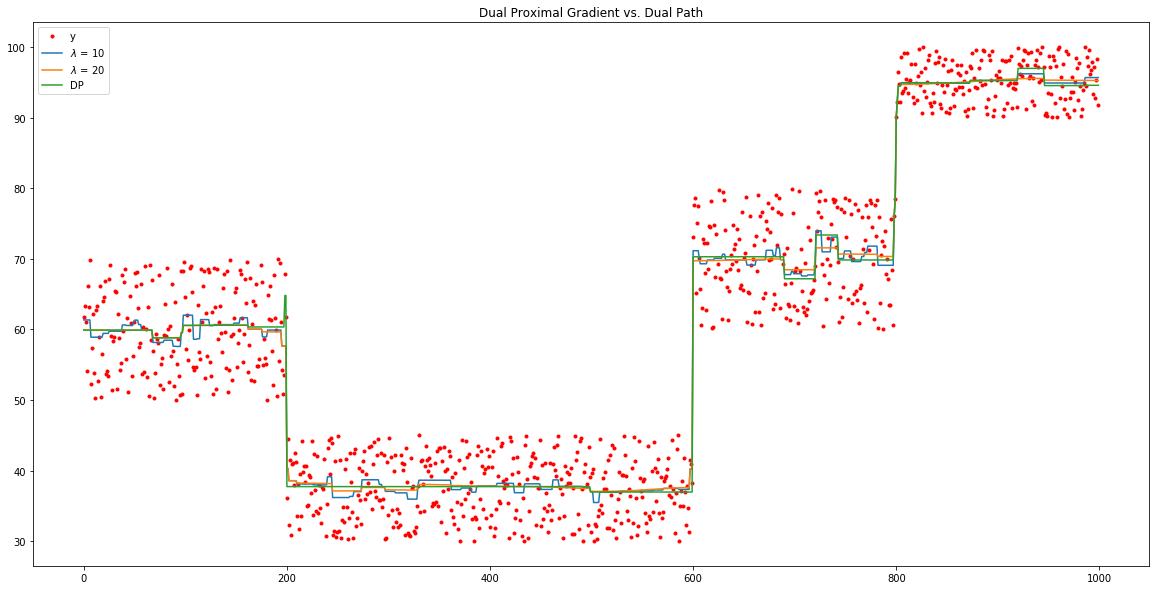

In [13]:
plt.clf()
plt.figure(figsize=(20,10))
plt.plot(y, 'r.',label='y')
# plt.plot(beta_dpg0,label='$\lambda$ = 0')
# plt.plot(beta_dpg5,label='$\lambda$ = 5')
plt.plot(beta_dpg10,label='$\lambda$ = 10')
plt.plot(beta_dpg20,label='$\lambda$ = 20')
plt.plot(beta_dp,label='DP')
plt.title('Dual Proximal Gradient vs. Dual Path')
plt.legend()
plt.show()

## Graph (Total Variation Denoising)

### Primal Subgradient Method

In [14]:
# Load image

from PIL import Image
import matplotlib.image as mpimg

# orig_img = Image.open('data/randompic.png').convert('L')
# orig_img.save('data/randompic_greyscale.png')
# corr_img = Image.open('data/randompic_corrupted.png').convert('L')
# corr_img.save('data/randompic_greyscale_corrupted.png')

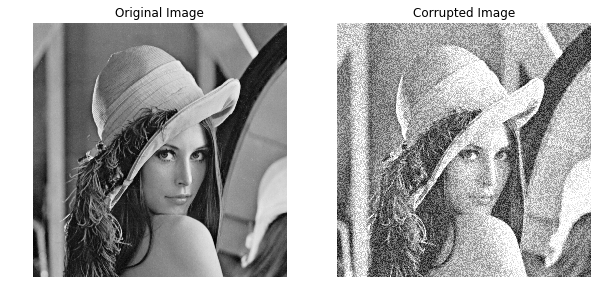

In [4]:
def loadImage():
    # Convert to arrays.
    orig_img = Image.open("data/randompic_greyscale.png")
#     orig_img = Image.open("data/lena.png")
    # corr_img = Image.open("data/camus_greyscale_corrupted.png")
    # orig_img = mpimg.imread("data/randompic_greyscale.png")
    # corr_img = mpimg.imread("data/randompic_greyscale_corrupted.png")

    np.random.seed(1)
    p = 0.05

    Uorig = np.array(orig_img)
    row, col = Uorig.shape

    Known = np.ones((row, col))
    for i in xrange(row):
        for j in xrange(col):
            if np.random.random() > (1-p):
                Known[i, j] = 0
    
#     size1 = Known[Known == 0].shape
#     Known[Known == 0] = 0.05*rn.random((size1,)) + 0.5
#     print Known
#     Ucorr = Known*Uorig
    Ucorr = Uorig + 100*rn.random((row, col))
    Ucorr[Ucorr > 255] = 255
    Ucorr[Ucorr < 0] = 0
    corr_img = Image.fromarray(np.uint8(Ucorr))
    corr_img.save('data/randompic_greyscale_corrupted.png')
#     corr_img.save('data/lena_corrupted.png')
    return Ucorr, corr_img, orig_img

Ucorr, corr_img, orig_img = loadImage()

%matplotlib inline
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
print ax
ax[0].imshow(np.asarray(orig_img),cmap='gray');
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(np.asarray(corr_img),cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

In [5]:
def denoisingMat2DGrid(size):
    add = np.eye(size)
    sub = -np.eye(size)
    D = np.concatenate((add,sub),axis = 1)
    return D

def denoisingMatGraph(row, col):
    D1 = np.zeros(((row)*(col-1),row*col))
    D2 = np.zeros(((row-1)*(col),row*col))
    DSegmentRow = denoisingMat(col)
    DSegmentCol = denoisingMat2DGrid(col)
    for i in range(row):
        startRow = i*(col-1)
        endRow = (i+1)*(col-1)
        startCol = i*(col)
        endCol = (i+1)*(col)
        D1[startRow:endRow,startCol:endCol] = DSegmentRow
    for i in range(row-1):
        startRow = i*(col)
        endRow = (i+1)*(col)
        startCol = i*(col)
        endCol = (i+2)*(col)
        D2[startRow:endRow,startCol:endCol] = DSegmentCol
    D = np.concatenate((D1, D2), axis = 0)
    return D

In [6]:
def denoisingMatGraphSparse(row,col):
    D1 = sp.csr_matrix(((row)*(col-1),row*col))
    D2 = sp.csr_matrix(((row-1)*(col),row*col))
    DSegmentRow = sp.csr_matrix(denoisingMat(col))
    DSegmentCol = sp.csr_matrix(denoisingMat2DGrid(col))
    for i in range(row):
        startRow = i*(col-1)
        endRow = (i+1)*(col-1)
        startCol = i*(col)
        endCol = (i+1)*(col)
        D1[startRow:endRow,startCol:endCol] = DSegmentRow
    for i in range(row-1):
        startRow = i*(col)
        endRow = (i+1)*(col)
        startCol = i*(col)
        endCol = (i+2)*(col)
        D2[startRow:endRow,startCol:endCol] = DSegmentCol
    D = sp.vstack([D1, D2])
    return D

In [7]:
def subgradientGraph(y, beta, D, t, lam, c=1e-1):
    betaSp = sp.csr_matrix(beta)
    ySp = sp.csr_matrix(y)
    delF1 = betaSp - ySp
    dotProd1 = D.dot(betaSp)
    dotProd1[dotProd1 > 0] = 1
    dotProd1[dotProd1 < 0] = -1
    delF2 = D.T.dot(dotProd1)*lam
    delF = delF1 + delF2
    betaSp = betaSp - c/(np.sqrt(t+1))*(delF)
    beta = betaSp.toarray()
    return beta

In [8]:
def descentGraph(update, Ucorr, reg, T=int(0.5e3)):
    row, col = Ucorr.shape
    y = np.reshape(Ucorr, (-1, 1))
    D = denoisingMatGraphSparse(row, col)
    beta = np.zeros((y.shape[0],1))
    error = []
    l1 = []
    for t in xrange(T):
        beta = update(y, beta, D, t, reg)
        betaSp = sp.csr_matrix(beta)
        # record error and l1 norm
        if (t % 100 == 0) or (t == T - 1):
            error.append(la.norm(beta - y))
            l1.append(np.sum(np.abs(D.dot(betaSp).toarray())))
            print t
            assert not np.isnan(error[-1])
    
    beta = np.reshape(beta, (row, col))
    return Ucorr, beta, error, l1

In [12]:
Ucorr, beta_sg_graph, error_sg_graph, l1_sg_graph = descentGraph(subgradientGraph, Ucorr, reg=20)

C:\ProgramData\Anaconda2\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


0
100
200
300
400
499


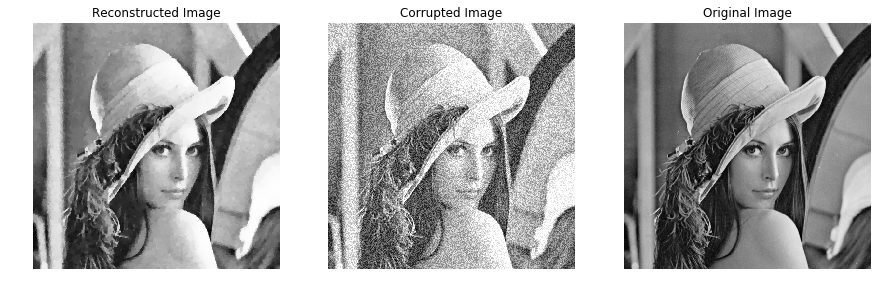

In [13]:
reconstruct_img = Image.fromarray(np.uint8(beta_sg_graph))

%matplotlib inline
fig, ax = plt.subplots(1, 3,figsize=(15, 10))
print ax
ax[0].imshow(np.asarray(reconstruct_img),cmap='gray');
ax[0].set_title("Reconstructed Image")
ax[0].axis('off')
ax[1].imshow(np.asarray(corr_img),cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
ax[2].imshow(np.asarray(orig_img),cmap='gray');
ax[2].set_title("Original Image")
ax[2].axis('off');

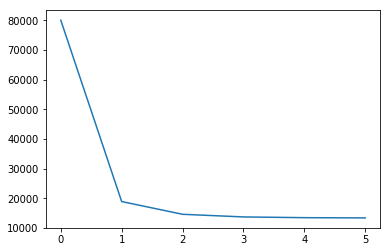

In [14]:
plt.plot(error_sg_graph)

### Dual Proximal Gradient Method

In [176]:
def gradientDualProxSparse(y, u, D, lam, c=1e-1):
    uSp = sp.csr_matrix(u)
    ySp = sp.csr_matrix(y)
    dotProd1 = D.T.dot(uSp)
    sum1 = ySp - dotProd1
    delFStar = -D.dot(sum1)
    uSp = uSp - c*(delFStar)
    uSp[uSp > lam] = lam
    uSp[uSp < -lam] = -lam
    u = uSp.toarray()
    return u

def costFuncDualProxSparse(y, v):
    vSp = sp.csr_matrix(v)
    ySp = sp.csr_matrix(y)
    dotProd1 = ySp.T.dot(ySp)
    dotProd2 = (ySp+vSp).T.dot((ySp+vSp))
    fVal = 0.5*(dotProd1 - dotProd2).toarray()
    return fVal

In [177]:
def descentDualProxGraph(update, Ucorr, reg, T=int(1e3)):
    row, col = Ucorr.shape
    y = np.reshape(Ucorr, (-1, 1))
    D = denoisingMatGraphSparse(row, col)
#     print D.shape
#     D = trendFilteringLinearMat(size)
#     beta = np.zeros((size,1))
    u = np.zeros((D.shape[0],1))
#     print u.shape
    
    error = []
    l1 = []
    for t in xrange(T):
        u = update(y, u, D, reg)
        # record error and l1 norm
        if (t % 100 == 0) or (t == T - 1):
            uSp = sp.csr_matrix(u)
            ySp = sp.csr_matrix(y)
            vSp = -D.T.dot(uSp)
            v = vSp.toarray()
#             beta = y - np.dot(D.T,u)
            betaSp = ySp + vSp 
#             print betaSp.shape
#             error.append(la.norm(beta - y))
            error.append(costFuncDualProxSparse(y, v))
            l1.append(np.sum(np.abs(D.dot(betaSp).toarray())))
            print t
            assert not np.isnan(error[-1])
    
    beta = betaSp.toarray()
    beta = np.reshape(beta, (row, col))
    return beta, error, l1

In [178]:
beta_dpg_graph, error_dpg_graph, l1_dpg_graph = descentDualProxGraph(gradientDualProxSparse, Ucorr, reg=10)

0
100
200
300
400
500
600
700
800
900
999


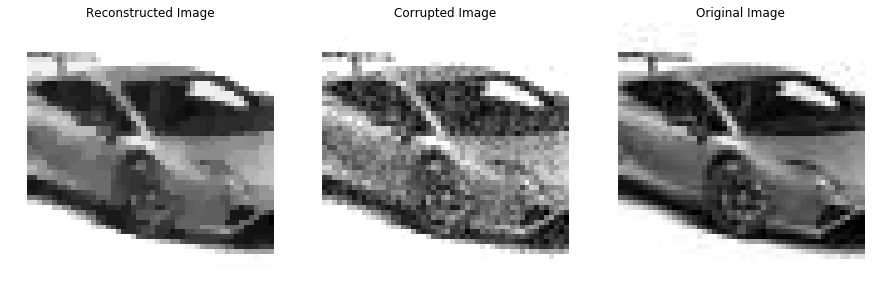

In [179]:
reconstruct_img_dpg = Image.fromarray(np.uint8(beta_dpg_graph))

%matplotlib inline
fig, ax = plt.subplots(1, 3,figsize=(15, 10))
print ax
ax[0].imshow(np.asarray(reconstruct_img_dpg),cmap='gray');
ax[0].set_title("Reconstructed Image")
ax[0].axis('off')
ax[1].imshow(np.asarray(corr_img),cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
ax[2].imshow(np.asarray(orig_img),cmap='gray');
ax[2].set_title("Original Image")
ax[2].axis('off');

### Fast Dual Path Algorithm

In [139]:
def descentDualPathGraph(Ucorr, reg):
    row, col = Ucorr.shape
    y = np.reshape(Ucorr, (-1, 1))
#     print y.shape
    D = denoisingMatGraphSparse(row, col)
    totalSet = np.arange(D.shape[0])
#     print D.shape
    x = spla.lsqr(D.T,y.flatten())
#     print 'first'
    u = x[0]
#     print u
    uVec = np.expand_dims(u,1)
#     print uVec.shape
#     print np.dot(D.T,uVec).shape
    beta = y - D.T.dot(uVec)
    lam = np.max(np.abs(u))
    iHit = np.argmax(np.abs(u))
    B = np.array([iHit])
    sgn = np.sign(u[iHit])
    s = np.array([sgn])
    counter = 0
    
    while lam > 0:
        print counter
        counter = counter + 1
        BMinus = setExclusion(B, totalSet)
        if BMinus.size == 0:
            break
        DBMinus = D[BMinus,:]
#         print DBMinus
        DB = D[B,:]
        x1 = spla.lsqr(DBMinus.T,y.flatten())
#         print 'here'
        x2 = spla.lsqr(DBMinus.T, DB.T.dot(np.expand_dims(s,1)))
#         print 'now'
        a = x1[0]
        b = x2[0]
        tHit, iHit = hittingCoordinate(a, b, BMinus, lam)
        tLeave, iLeave = leavingCoordinate(a, b, DB, DBMinus, y, s, B)
        if tHit>=tLeave:
            lam = tHit
            BOld = B.copy()
            B = np.append(B,iHit)
            sgn = np.sign(u[iHit])
            sOld = s.copy()
            s = np.append(s, sgn)
        else:
            lam = tLeave
            BOld = B.copy()
            sOld = s.copy()
            B = np.delete(B,iLeave,0)
            s = np.delete(s,iLeave,0)
        print lam
        if lam < reg:
            u[BMinus] = a - reg*b
            u[BOld] = reg*sOld
            break
    u = np.expand_dims(u,1)
    beta = y - D.T.dot(u)
    beta = np.reshape(beta, (row, col))
    return beta    
                   
def leavingCoordinate(a, b, DB, DBMinus, y, s, B):
    a = np.expand_dims(a,1)
    b = np.expand_dims(b,1)
    s = np.expand_dims(s,1)
    c = s*(DB.dot(y)-DB.dot(DBMinus.T.dot(a)))
#     print DB.dot(y)
#     print DB.dot(DBMinus.T.dot(a))
    c = c.flatten()
    c[np.abs(c)<1e-4] = 0.
#     print c
    d = s*(DB.dot(DB.T.dot(s))-DB.dot(DBMinus.T.dot(b)))
    d = d.flatten()
    d[np.abs(d)<1e-5] = 0.
#     print d
    if c[c<0].size == 0 or d[d<0].size == 0:
        t = 0
        i = 0
    else:
        cIdx = np.where(c<0)[0]
        dIdx = np.where(d<0)[0]
        check = np.intersect1d(cIdx,dIdx)
#         print check
#         check = np.where(cIdx == dIdx)[0]
#         print check
        if check.size == 0:
            t = 0
            i = 0
        else:
            print c[check],d[check]
            print c[check]/d[check]
            t = np.max(c[check]/d[check])
            print t
            i = np.argmax(c[check]/d[check])
            print i
            i = check[i]
#             print c[check],d[check]
    return t, i
  

In [140]:
beta_dp_graph = descentDualPathGraph(Ucorr, reg=670)

0
1052.17035344
1
1050.6033924
2
1047.43203353
3
1046.27643607
4
1046.00773506
5
1040.78518988
6
1029.85155985
7
1029.72413575
8
1022.69985035
9
1021.22967504
10
1017.16036325
11
1000.34296002
12
999.683733244
13
998.553824836
14
996.833887033
15
995.885476677
16
993.934265574
17
993.650416009
18
992.914675209
19
985.643966604
20
984.616007769
21
984.573726118
22
981.979416598
23
979.258111021
24
978.503395516
25
978.139710217
26
977.760399185
27
976.907337614
28
975.690287514
29
975.211775576
30
975.090497324
31
974.242769857
32
971.475051293
33
971.354276599
34
969.606331159
35
969.534681917
36
968.671972435
37
967.840270347
38
966.222255655
39
965.699651127
40
965.405180841
41
965.346457061
42
964.076248537
43
963.729082927
44
963.602006351
45
963.322108377
46
960.761861253
47
960.665353134
48
959.266940528
49
959.165941967
50
958.863498208
51
957.646240861
52
957.359949383
53
956.679203628
54
956.281078481
55
955.566663048
56
954.362525431
57
954.216867923
58
953.519369112
59
953.4

[-4.91964832 -4.91959593 -4.91952848 -4.91950015 -4.91952368 -4.91949024
 -4.91942446 -4.91942336 -4.91942216 -4.9194548 ] [-0.00909093 -0.00909094 -0.00909093 -0.00909095 -0.00909096 -0.00909096
 -0.00909094 -0.00909091 -0.00909089 -0.00909083]
[ 541.16000503  541.15377675  541.14661634  541.14249573  541.1447452
  541.14066597  541.13500847  541.13627593  541.13769272  541.14471333]
541.160005033
0
790.798017679
197
[-4.91960851 -4.91957369 -4.91959603 -4.91959641 -4.91951679 -4.919469
 -4.91945482 -4.91942311 -4.91942273 -4.91937032] [-0.00909095 -0.00909093 -0.00909093 -0.00909091 -0.00909094 -0.00909094
 -0.00909092 -0.0090909  -0.00909089 -0.00909087]
[ 541.15433552  541.15202341  541.15417555  541.15565638  541.14522149
  541.13973211  541.13960621  541.13736925  541.13745783  541.1330187 ]
541.155656375
3
789.279926298
198
[-4.9194963  -4.91951878 -4.91948538 -4.91942945 -4.9194331  -4.91948016
 -4.9195056  -4.91950888 -4.91946458 -4.91948627] [-0.00909094 -0.00909094 -0.009090

[-13.61265255 -13.61263449 -13.61268016 -13.61271258 -13.61268096
 -13.61266551 -13.61266226 -13.61266016 -13.6126227 ] [-0.02020207 -0.02020205 -0.02020203 -0.02020203 -0.02020202 -0.02020199
 -0.02020198 -0.02020202 -0.02020204]
[ 673.82464295  673.824284    673.82748646  673.82886957  673.82786193
  673.82807611  673.82802213  673.82680573  673.82414419]
673.828869566
3
750.564363312
218
[-13.61265878 -13.61264909 -13.61270052 -13.61272913 -13.6126967
 -13.61268594 -13.61268681 -13.61268355 -13.61264084] [-0.02020207 -0.02020207 -0.02020204 -0.02020203 -0.02020201 -0.02020199
 -0.02020199 -0.02020203 -0.02020205]
[ 673.82495289  673.82456548  673.82804546  673.82967708  673.82884974
  673.82905734  673.82901954  673.82746412  673.82457479]
673.829677082
3
750.513360972
219
[-13.61266055 -13.61265551 -13.61270517 -13.61273779 -13.61269955
 -13.61268344 -13.61268776 -13.61268784 -13.61264835] [-0.02020207 -0.02020207 -0.02020204 -0.02020203 -0.02020201 -0.02020199
 -0.02020199 -0.0202

[-13.61268106 -13.61271503 -13.61269631 -13.6127344  -13.61274503
 -13.61279652 -13.61278919 -13.61280866 -13.61275553] [-0.02020197 -0.02020198 -0.020202   -0.02020202 -0.02020203 -0.02020202
 -0.02020202 -0.02020201 -0.02020204]
[ 673.82955068  673.8305706   673.82925468  673.83029514  673.83069802
  673.83355352  673.83322689  673.83432864  673.83080957]
673.834328637
7
733.75281332
240
[-13.61266752 -13.6127125  -13.61269976 -13.61274027 -13.61275312
 -13.61280133 -13.61278658 -13.61279887 -13.61274474] [-0.02020199 -0.02020199 -0.020202   -0.02020201 -0.02020203 -0.02020204
 -0.02020203 -0.02020202 -0.02020204]
[ 673.82810387  673.83044109  673.82923161  673.83086901  673.83088116
  673.83285447  673.83274968  673.83366302  673.83034389]
673.833663017
7
733.393079789
241
[-13.61267059 -13.61271288 -13.61269743 -13.61273348 -13.61274472
 -13.61279677 -13.61278771 -13.61280521 -13.61275073] [-0.02020197 -0.02020198 -0.02020199 -0.02020202 -0.02020203 -0.02020203
 -0.02020202 -0.0202

[-13.61284806 -13.61280876 -13.61277846 -13.61270435 -13.61273439
 -13.61272703 -13.61270986 -13.61272278 -13.61273611] [-0.02020191 -0.02020194 -0.02020198 -0.02020198 -0.02020198 -0.02020202
 -0.02020208 -0.02020211 -0.0202021 ]
[ 673.83973798  673.83663541  673.83372292  673.83034472  673.83180477
  673.83012827  673.82724002  673.82692208  673.82765633]
673.83973798
0
707.762041991
261
[-13.61283957 -13.61278392 -13.61273435 -13.61273383 -13.61272533
 -13.61271461 -13.61275063 -13.61273976 -13.61274231] [-0.02020191 -0.02020192 -0.02020196 -0.02020198 -0.02020199 -0.02020203
 -0.02020208 -0.0202021  -0.02020212]
[ 673.8393715   673.83615802  673.83230641  673.83170415  673.83082464
  673.82909206  673.82925642  673.82793974  673.82750512]
673.839371498
0
706.148137531
262
[-13.61283896 -13.61277905 -13.61272986 -13.61273123 -13.61272414
 -13.61271024 -13.61274262 -13.61272525 -13.61272451] [-0.02020192 -0.02020193 -0.02020196 -0.02020198 -0.02020199 -0.02020202
 -0.02020207 -0.0202

[-13.61248265 -13.61249334 -13.61252868 -13.61252225 -13.61250384
 -13.61249252 -13.61245059 -13.61243991 -13.61244953] [-0.02020198 -0.02020201 -0.02020203 -0.02020204 -0.02020204 -0.02020203
 -0.02020203 -0.02020201 -0.02020199]
[ 673.81918892  673.81861002  673.8197529   673.81902463  673.81813864
  673.81791977  673.81609772  673.81606623  673.81715308]
673.819752896
2
686.376593486
283
[-13.612613   -13.61261592 -13.61260567 -13.61258118 -13.61256713
 -13.61255655 -13.61248975 -13.61245662 -13.61246502] [-0.02020201 -0.02020203 -0.02020204 -0.02020205 -0.02020205 -0.02020204
 -0.02020203 -0.02020201 -0.02020198]
[ 673.82483503  673.82424229  673.82329806  673.82169981  673.82114527
  673.82097152  673.81787095  673.81678385  673.8183787 ]
673.824835032
0
686.178901695
284
[-13.61253898 -13.61249648 -13.61244259 -13.61240673 -13.61241342
 -13.61239091 -13.61242571 -13.61243879 -13.61244058] [-0.02020202 -0.02020202 -0.02020204 -0.02020205 -0.02020205 -0.02020203
 -0.020202   -0.020

[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.8130716   673.81429187  673.81360805
  673.8138121   673.81124768  673.81071769  673.81838711]
673.818387113
8
673.818387113
305
[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.86655771  98.86801415  98.86699044]
98.8712587905
0
673.813961934
306
[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.813

[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.86655771  98.86801415  98.86699044]
98.8712587905
0
673.813961934
328
[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.8130716   673.81429187  673.81360805
  673.8138121   673.81124768  673.81071769  673.81838711]
673.818387113
8
673.818387113
329
[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.

[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.86655771  98.86801415  98.86699044]
98.8712587905
0
673.813961934
352
[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.8130716   673.81429187  673.81360805
  673.8138121   673.81124768  673.81071769  673.81838711]
673.818387113
8
673.818387113
353
[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.

[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.8130716   673.81429187  673.81360805
  673.8138121   673.81124768  673.81071769  673.81838711]
673.818387113
8
673.818387113
375
[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.86655771  98.86801415  98.86699044]
98.8712587905
0
673.813961934
376
[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.813

[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.8130716   673.81429187  673.81360805
  673.8138121   673.81124768  673.81071769  673.81838711]
673.818387113
8
673.818387113
399
[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.86655771  98.86801415  98.86699044]
98.8712587905
0
673.813961934
400
[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.813

[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.8130716   673.81429187  673.81360805
  673.8138121   673.81124768  673.81071769  673.81838711]
673.818387113
8
673.818387113
423
[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.86655771  98.86801415  98.86699044]
98.8712587905
0
673.813961934
424
[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.813

[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.8130716   673.81429187  673.81360805
  673.8138121   673.81124768  673.81071769  673.81838711]
673.818387113
8
673.818387113
447
[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.86655771  98.86801415  98.86699044]
98.8712587905
0
673.813961934
448
[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.813

[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.86655771  98.86801415  98.86699044]
98.8712587905
0
673.813961934
470
[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.8130716   673.81429187  673.81360805
  673.8138121   673.81124768  673.81071769  673.81838711]
673.818387113
8
673.818387113
471
[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.

[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.8130716   673.81429187  673.81360805
  673.8138121   673.81124768  673.81071769  673.81838711]
673.818387113
8
673.818387113
493
[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.86655771  98.86801415  98.86699044]
98.8712587905
0
673.813961934
494
[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.813

[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.86655771  98.86801415  98.86699044]
98.8712587905
0
673.813961934
516
[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.8130716   673.81429187  673.81360805
  673.8138121   673.81124768  673.81071769  673.81838711]
673.818387113
8
673.818387113
517
[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.

[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.8130716   673.81429187  673.81360805
  673.8138121   673.81124768  673.81071769  673.81838711]
673.818387113
8
673.818387113
539
[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.86655771  98.86801415  98.86699044]
98.8712587905
0
673.813961934
540
[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.813

[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.8130716   673.81429187  673.81360805
  673.8138121   673.81124768  673.81071769  673.81838711]
673.818387113
8
673.818387113
563
[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.86655771  98.86801415  98.86699044]
98.8712587905
0
673.813961934
564
[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.813

[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.8130716   673.81429187  673.81360805
  673.8138121   673.81124768  673.81071769  673.81838711]
673.818387113
8
673.818387113
587
[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.86655771  98.86801415  98.86699044]
98.8712587905
0
673.813961934
588
[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.813

[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.8130716   673.81429187  673.81360805
  673.8138121   673.81124768  673.81071769  673.81838711]
673.818387113
8
673.818387113
611
[-3.3384442  -3.33829724 -3.338301   -3.33828269 -3.33824506 -3.33828719
 -3.3383337  -3.33830267] [-0.03376557 -0.03376558 -0.03376559 -0.03376556 -0.03376557 -0.03376559
 -0.03376556 -0.03376559]
[ 98.87125879  98.86687309  98.86695158  98.86648649  98.8653475
  98.86655771  98.86801415  98.86699044]
98.8712587905
0
673.813961934
612
[-13.61244587 -13.61240398 -13.61237625 -13.61238336 -13.61237913
 -13.61239723 -13.61236249 -13.61237394 -13.61250301] [-0.02020203 -0.02020204 -0.02020201 -0.02020198 -0.02020199 -0.02020202
 -0.02020204 -0.02020207 -0.02020204]
[ 673.81572549  673.81338496  673.813

KeyboardInterrupt: 

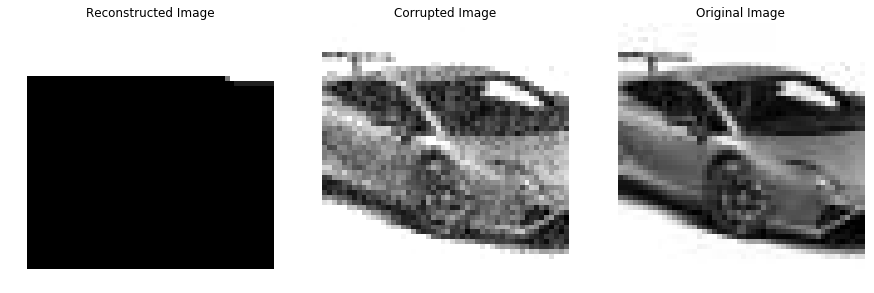

In [130]:
reconstruct_img_dp = Image.fromarray(np.uint8(beta_dp_graph))

%matplotlib inline
fig, ax = plt.subplots(1, 3,figsize=(15, 10))
print ax
ax[0].imshow(np.asarray(reconstruct_img_dp),cmap='gray');
ax[0].set_title("Reconstructed Image")
ax[0].axis('off')
ax[1].imshow(np.asarray(corr_img),cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
ax[2].imshow(np.asarray(orig_img),cmap='gray');
ax[2].set_title("Original Image")
ax[2].axis('off');

In [131]:
beta_dp_graph

array([[ 178.33265733,  178.33266664,  178.33268944, ...,  178.33316967,
         178.33316922,  178.3331648 ],
       [ 178.33266904,  178.33266423,  178.33268678, ...,  178.33312724,
         178.33314616,  178.33315125],
       [ 178.33268033,  178.3326809 ,  178.33269687, ...,  178.33311724,
         178.33314656,  178.33316198],
       ..., 
       [ 155.00504199,  155.00514261,  155.0051222 , ...,  155.00545559,
         155.00550279,  155.0055745 ],
       [ 155.00508312,  155.00509944,  155.0051258 , ...,  155.00540707,
         155.00543849,  155.0054317 ],
       [ 155.00513577,  155.00511786,  155.00510628, ...,  155.00551747,
         155.00544903,  155.00540175]])